In [6]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv("../.env")
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
MODEL_TRAINING_DATASET_PATH=os.getenv("MODEL_TRAINING_DATASET_PATH")
GENERATED_DATASETS_PATH=os.getenv("GENERATED_DATASETS_PATH")


sys.path.append("../")
from cpsl_datasets.gnn_node_ds import GnnNodeDS

from mmwave_model_integrator.input_encoders._node_encoder import _NodeEncoder
from mmwave_model_integrator.ground_truth_encoders._gt_node_encoder import _GTNodeEncoder
from mmwave_model_integrator.plotting.plotter_gnn_pc_processing import PlotterGnnPCProcessing
from mmwave_model_integrator.model_runner.gnn_runner import GNNRunner
from mmwave_model_integrator.torch_training.models.SAGEGnn import SageGNNClassifier
from mmwave_model_integrator.plotting.movie_generator_gnn import MovieGeneratorGNN


In [7]:
#initialize the dataset
config_label = "RaGNNarok_1fp_20fh_0_50_th_5mRng_0_2_res"
dataset_path = os.path.join(DATASET_PATH,"{}_eval_imaging".format(config_label))
dataset = GnnNodeDS(
    dataset_path=dataset_path,
    node_folder="nodes",
    label_folder="labels"
)
print(dataset_path)


found 2783 node samples
found 2783 label samples
/data/radnav/radnav_model_datasets/RaGNNarok_1fp_20fh_0_50_th_5mRng_0_2_res_eval_imaging


In [8]:
#initialize the encoder and decoder
input_encoder = _NodeEncoder()
ground_truth_encoder = _GTNodeEncoder()
plotter = PlotterGnnPCProcessing()

#testing the output

runner = GNNRunner(
    model= SageGNNClassifier(
        in_channels=4,
        hidden_channels=16,
        out_channels=1
    ),state_dict_path="/home/david/Documents/odometry/submodules/mmwave_model_integrator/scripts/working_dir/RaGNNarok/RaGNNarok_1fp_20fh_0_50_th_5mRng_0_2_res.pth",
    cuda_device="cpu",
    edge_radius=10.0
)

movie_generator = MovieGeneratorGNN(
    gnn_ds=dataset,
    plotter=plotter,
    input_encoder=input_encoder,
    runner=runner,
    decoder=None,
    ground_truth_encoder=ground_truth_encoder,
    temp_dir_path=os.path.join(os.getenv("MOVIE_TEMP_DIRECTORY"),config_label)
)

_ModelRunner: using CPU
Total number of parameters: 705
found temp dir: /home/david/Downloads/radnav_temp_dir/RaGNNarok_1fp_20fh_0_50_th_5mRng_0_2_res
clearing temp directory /home/david/Downloads/radnav_temp_dir/RaGNNarok_1fp_20fh_0_50_th_5mRng_0_2_res


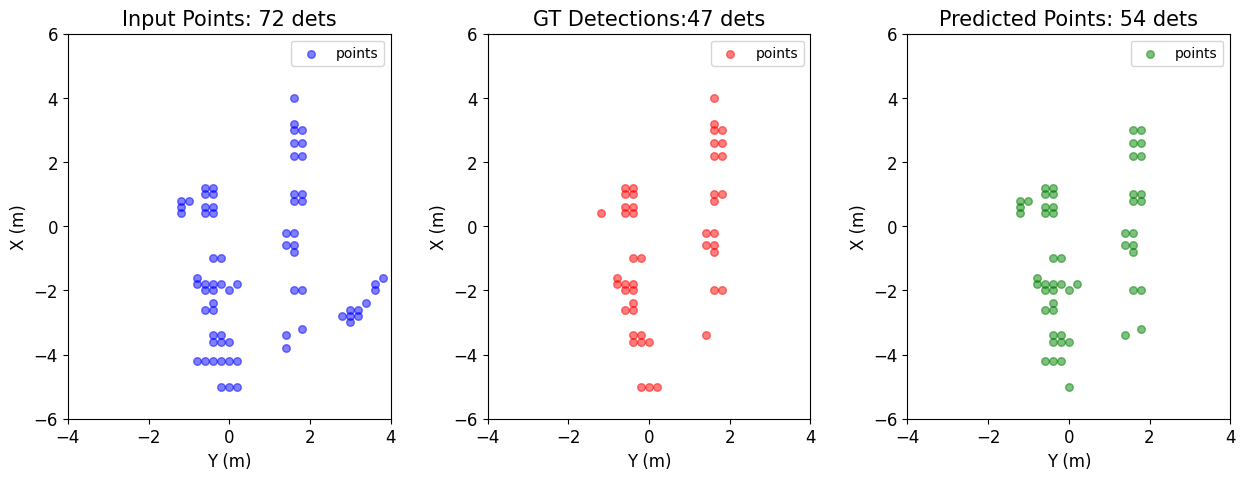

In [9]:
#plot a sample from the training dataset
idx = 980 #980 good for imaging #3000 good on 10fp_20fh_0_50_th_5mRng_0_2_res_train
nodes = dataset.get_node_data(idx)
labels = dataset.get_label_data(idx)
plotter.plot_compilation(
    input_data=nodes,
    gt_data=labels,
    input_encoder=input_encoder,
    ground_truth_encoder=ground_truth_encoder,
    runner=runner,
    show=True
)

In [10]:
#quick speed comparison
from tqdm import tqdm

for i in tqdm(range(dataset.num_frames)):

    nodes = dataset.get_node_data(idx=i)
    labels = dataset.get_label_data(idx=i)

    pred = runner.make_prediction(nodes)

100%|██████████| 2783/2783 [00:03<00:00, 800.67it/s]


100%|██████████| 392/392 [00:18<00:00, 21.17it/s]


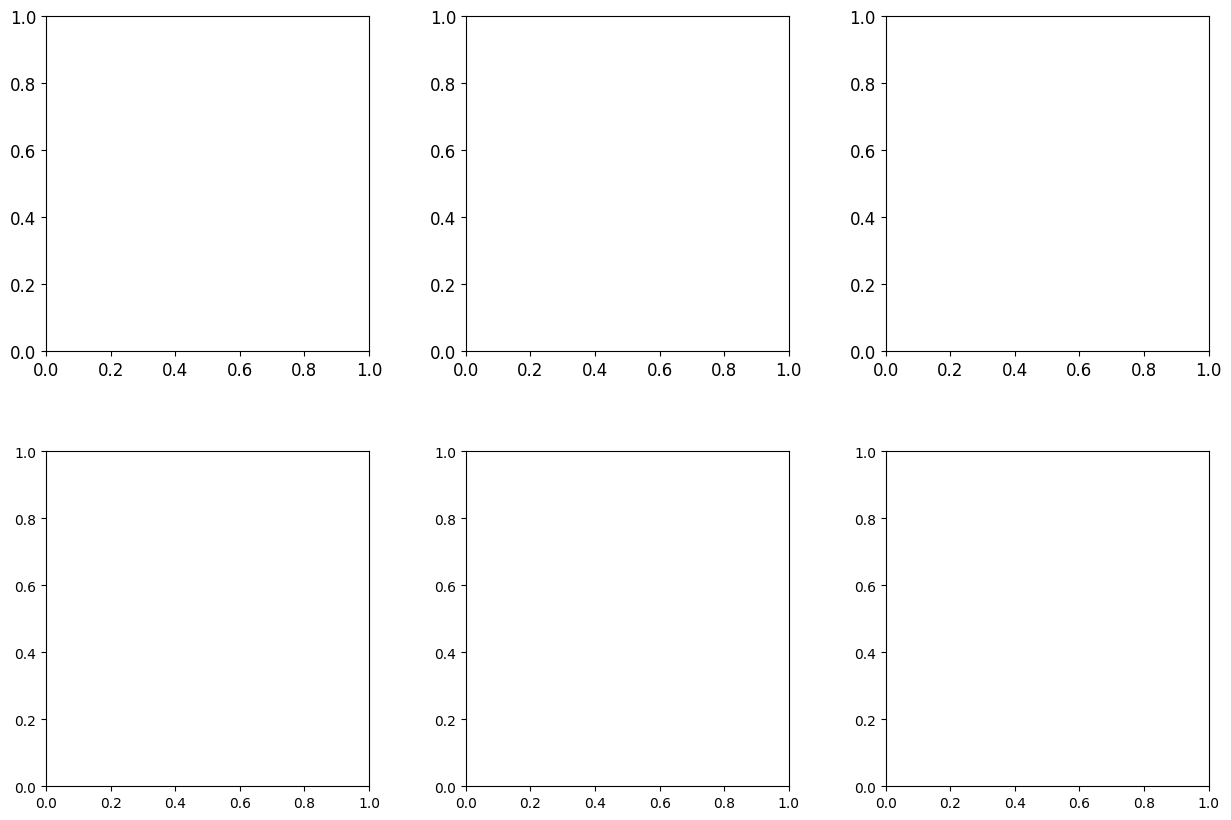

In [6]:
movie_generator.initialize_figure(
    nrows=2,
    ncols=3,
    figsize=(15,10),
    wspace=0.3,
    hspace=0.3
)

movie_generator.generate_movie_frames()

movie_generator.save_movie(video_file_name="{}.mp4".format("gnnSAGE_initial"),fps=20)